In [1]:
# Making necessary imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm


W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
horizontal_flip = True
rotation_augmentation = True
brightness_augmentation = True
shift_augmentation = True
random_noise_augmentation = True

#是否包含缺少关键点值的样本。 请注意，稍后将使用 Pandas 的 'ffill' 填充缺失值。
include_unclean_data = True    # Whether to include samples with missing keypoint values. Note that the missing values would however be filled using Pandas' 'ffill' later.

# 用于可视化各种增强的样本训练图像的索引
sample_image_index = 20    # Index of sample train image used for visualizing various augmentations

# 以度为单位的旋转角度（包括顺时针和逆时针旋转）
rotation_angles = [12]    # Rotation angle in degrees (includes both clockwise & anti-clockwise rotations)
# 以像素为单位的水平和垂直移动量（包括从所有 4 个角的移动）
pixel_shifts = [12]    # Horizontal & vertical shift amount in pixels (includes shift from all 4 corners)

NUM_EPOCHS = 80
BATCH_SIZE = 64


In [3]:
%%time

train_file = 'training.csv'
test_file = 'test.csv'
idlookup_file = 'IdLookupTable.csv'
train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
idlookup_data = pd.read_csv(idlookup_file)

Wall time: 2.88 s


In [4]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

# showing the data

In [5]:
train_data.head().T

0  \
left_eye_center_x                                                  66.033564   
left_eye_center_y                                                  39.002274   
right_eye_center_x                                                 30.227008   
right_eye_center_y                                                 36.421678   
left_eye_inner_corner_x                                            59.582075   
left_eye_inner_corner_y                                            39.647423   
left_eye_outer_corner_x                                            73.130346   
left_eye_outer_corner_y                                            39.969997   
right_eye_inner_corner_x                                           36.356571   
right_eye_inner_corner_y                                           37.389402   
right_eye_outer_corner_x                                           23.452872   
right_eye_outer_corner_y                                           37.389402   
left_eyebrow_inner_end_x                                           56.953263   
left_eyebrow_inner_end_y                                           29.033648   
left_eyebrow_outer_end_x                                           80.227128   
left_eyebrow_outer_end_y                                           32.228138   
right_eyebrow_inner_end_x                                          40.227609   
right_eyebrow_inner_end_y                                          29.002322   
right_eyebrow_outer_end_x                                          16.356379   
right_eyebrow_outer_end_y                                          29.647471   
nose_tip_x                                                         44.420571   
nose_tip_y                                                         57.066803   
mouth_left_corner_x                                                61.195308   
mouth_left_corner_y                                                79.970165   
mouth_right_corner_x                                               28.614496   
mouth_right_corner_y                                               77.388992   
mouth_center_top_lip_x                                             43.312602   
mouth_center_top_lip_y                                             72.935459   
mouth_center_bottom_lip_x                                          43.130707   
mouth_center_bottom_lip_y                                          84.485774   
Image                      238 236 237 238 240 240 239 241 241 243 240 23...   

                                                                           1  \
left_eye_center_x                                                  64.332936   
left_eye_center_y                                                  34.970077   
right_eye_center_x                                                 29.949277   
right_eye_center_y                                                 33.448715   
left_eye_inner_corner_x                                             58.85617   
left_eye_inner_corner_y                                            35.274349   
left_eye_outer_corner_x                                            70.722723   
left_eye_outer_corner_y                                            36.187166   
right_eye_inner_corner_x                                           36.034723   
right_eye_inner_corner_y                                           34.361532   
right_eye_outer_corner_x                                           24.472511   
right_eye_outer_corner_y                                           33.144443   
left_eyebrow_inner_end_x                                           53.987404   
left_eyebrow_inner_end_y                                           28.275949   
left_eyebrow_outer_end_x                                           78.634213   
left_eyebrow_outer_end_y                                           30.405923   
right_eyebrow_inner_end_x                                          42.728851   
right_eyebrow_inner_end_y                                          26.1460

In [6]:
test_data.head().T

0  \
ImageId                                                  1   
Image    182 183 182 182 180 180 176 169 156 137 124 10...   

                                                         1  \
ImageId                                                  2   
Image    76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...   

                                                         2  \
ImageId                                                  3   
Image    177 176 174 170 169 169 168 166 166 166 161 14...   

                                                         3  \
ImageId                                                  4   
Image    176 174 174 175 174 174 176 176 175 171 165 15...   

                                                         4  
ImageId                                                  5  
Image    50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...

In [7]:
idlookup_data.head().T

0                  1                   2  \
RowId                        1                  2                   3   
ImageId                      1                  1                   1   
FeatureName  left_eye_center_x  left_eye_center_y  right_eye_center_x   
Location                   NaN                NaN                 NaN   

                              3                        4  
RowId                         4                        5  
ImageId                       1                        1  
FeatureName  right_eye_center_y  left_eye_inner_corner_x  
Location                    NaN                      NaN

In [8]:
# 查看Image特征中是否有缺失的像素

print("Length of train data: {}".format(len(train_data)))
print("Number of Images with missing pixel values: {}".format(len(train_data) - int(train_data.Image.apply(lambda x: len(x.split())).value_counts().values)))

Length of train data: 7049
Number of Images with missing pixel values: 0


In [9]:
# 96*96的图象大小。
pow(len(train_data.iloc[0].Image.split()), 0.5)

96.0

In [10]:
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

有大量的缺失数据。且缺失数据大量都在4780左右。比例为67%

In [11]:
%%time

clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

# ffill填充方法：最后一个有效观察，进行填充
# bfill：后面一个有效观察，进行填充。


clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)

Wall time: 7.01 ms


Shape of clean_train_images: (2140, 96, 96, 1)
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)
Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)

Wall time: 13.4 s


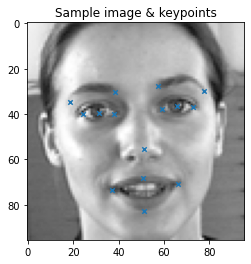

In [12]:
%%time

def load_images(image_data):
    # 加载每一张图象。
    # 将图象reshape乘H,W,C
    images = []
    for idx, sample in image_data.iterrows():
        image = np.array(sample['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)/255.
    return images

def load_keypoints(keypoint_data):
    # 加载keypoints，应该是目标函数。
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    return keypoint_features

clean_train_images = load_images(clean_train_data)
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

train_images = clean_train_images
train_keypoints = clean_train_keypoints
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Sample image & keypoints")

if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    # 将clean数据和unclean的数据连接起来。
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

# 数据增强

## 水平翻转

Shape of flipped_train_images: (2140, 96, 96, 1)
Shape of flipped_train_keypoints: (2140, 30)


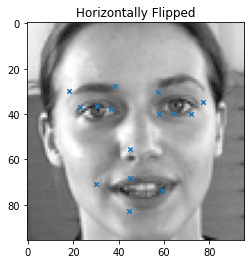

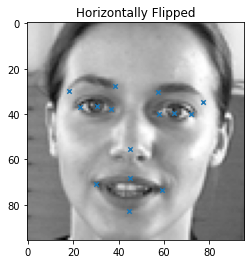

In [13]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=2)   # Flip column-wise (axis=2)
    # 进行图象翻转。
    for idx, sample_keypoints in enumerate(keypoints):
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx,coor in enumerate(sample_keypoints)])    # Subtract only X co-ordinates of keypoints from 96 for horizontal flipping
    return flipped_images, flipped_keypoints


# 水平翻转
if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images))
    train_keypoints = np.concatenate((train_keypoints, flipped_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(clean_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], axis, "Horizontally Flipped") 

## 旋转

Augmenting for angles (in degrees): 
12  -12  
Shape of rotated_train_images: (4280, 96, 96, 1)
Shape of rotated_train_keypoints: (4280, 30)



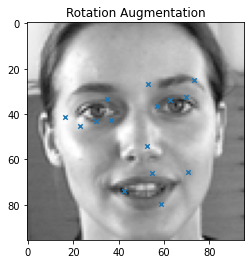

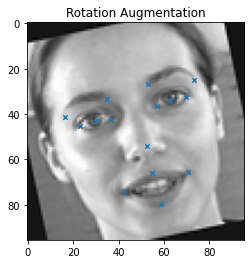

In [14]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    for angle in rotation_angles:    # Rotation augmentation for a list of angle values
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.     # Obtain angle in radians from angle in degrees (notice negative sign for change in clockwise vs anti-clockwise directions from conventional rotation to cv2's image rotation)
            # For train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
            # For train_keypoints
            for keypoint in keypoints:
                rotated_keypoint = keypoint - 48.    # Subtract the middle value of the image dimension
                for idx in range(0,len(rotated_keypoint),2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                rotated_keypoint += 48.   # Add the earlier subtracted value
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints

if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(clean_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], axis, "Rotation Augmentation")

## 明暗调节

Shape of altered_brightness_train_images: (4280, 96, 96, 1)
Shape of altered_brightness_train_keypoints: (4280, 30)


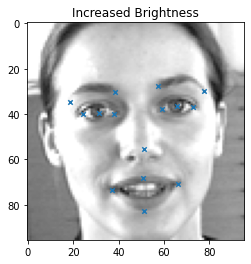

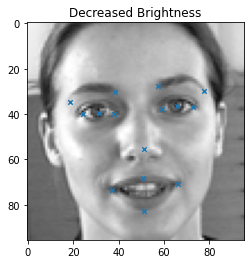

In [15]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    # Increased brightness by a factor of 1.2 & clip any values outside the range of [-1,1]
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    # Decreased brightness by a factor of 0.6 & clip any values outside the range of [-1,1]
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    return altered_brightness_images, np.concatenate((keypoints, keypoints))

if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, clean_train_keypoints)
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], axis, "Decreased Brightness") 

## 水平位移

Shape of shifted_train_images: (6350, 96, 96, 1)
Shape of shifted_train_keypoints: (6350, 30)


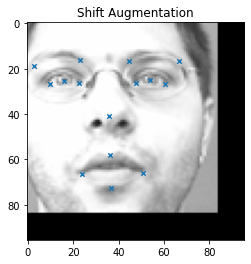

In [16]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:    # Augmenting over several pixel shift values
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(0.0<shifted_keypoint) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    return shifted_images, shifted_keypoints

if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], axis, "Shift Augmentation")

## 加随机噪声

Shape of noisy_train_images: (2140, 96, 96, 1)


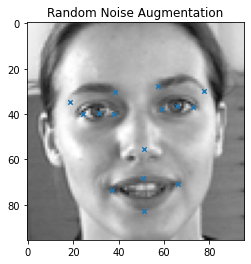

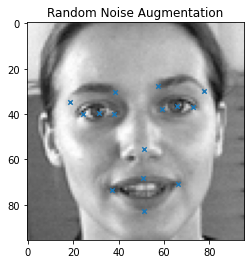

In [17]:
def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    # Adding random normal noise to the input image & clip the resulting noisy image between [-1,1]
        noisy_images.append(noisy_image.reshape(96,96,1))
    return noisy_images

if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    fig, axis = plt.subplots()
    plot_sample(clean_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], axis, "Random Noise Augmentation")

Shape of final train_images: (28379, 96, 96, 1)
Shape of final train_keypoints: (28379, 30)

 Clean Train Data: 


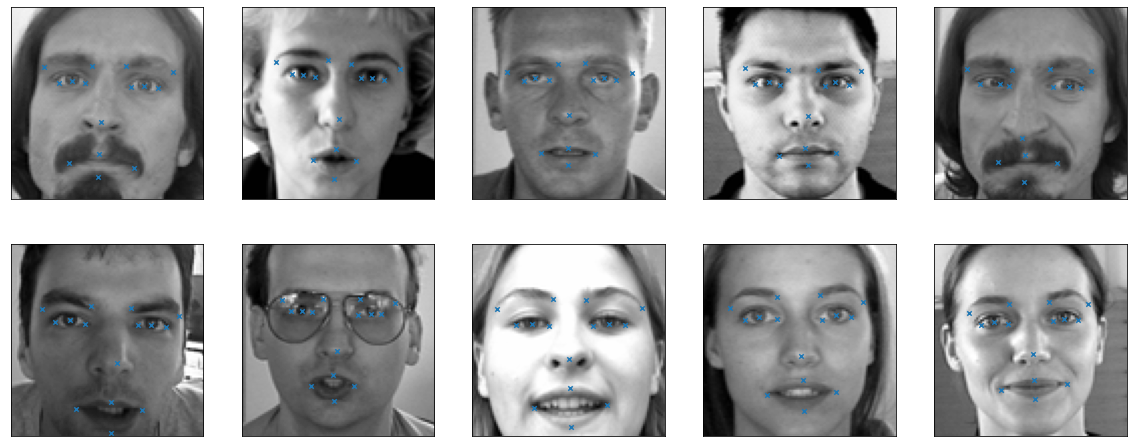

Unclean Train Data: 


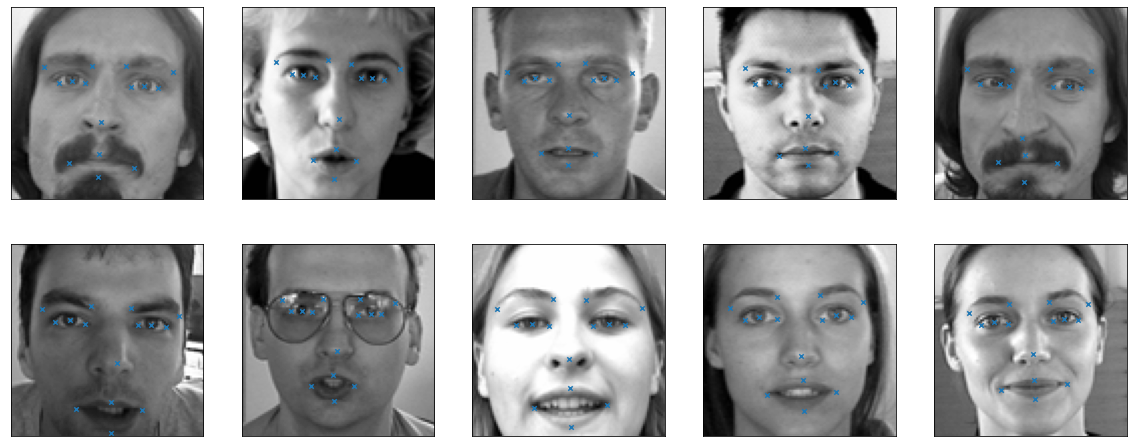

Horizontal Flip Augmentation: 


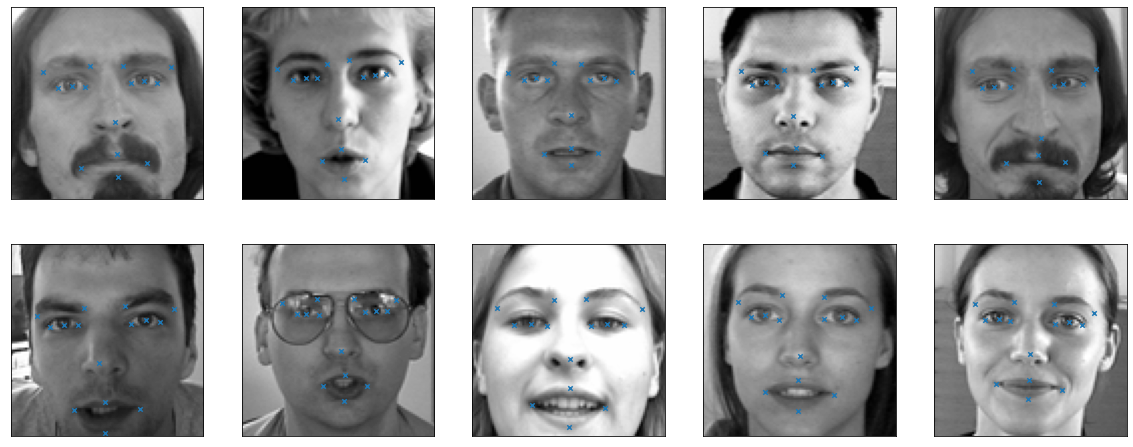

Rotation Augmentation: 


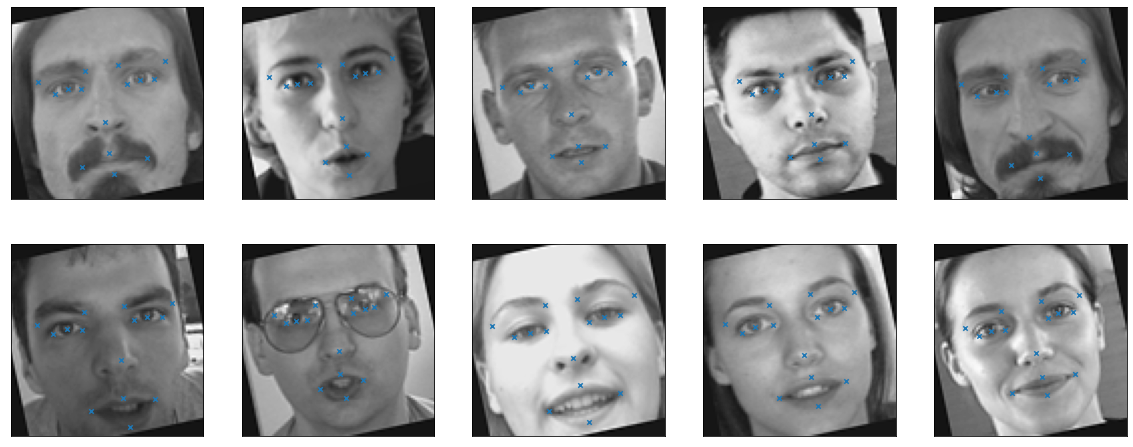

Brightness Augmentation: 


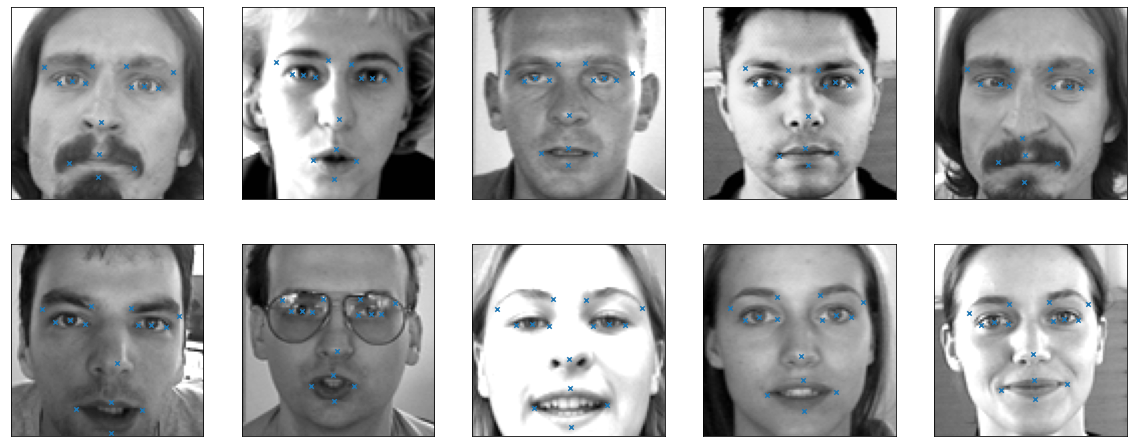

Shift Augmentation: 


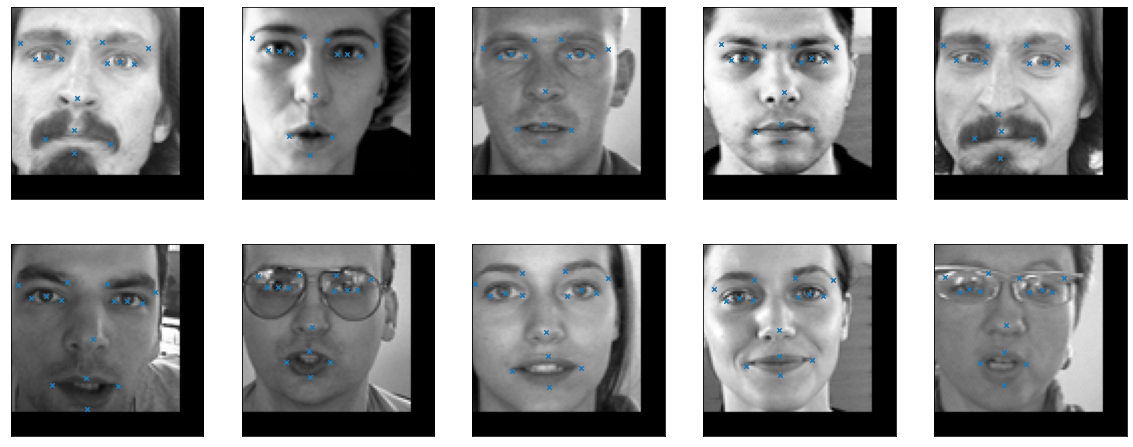

Random Noise Augmentation: 


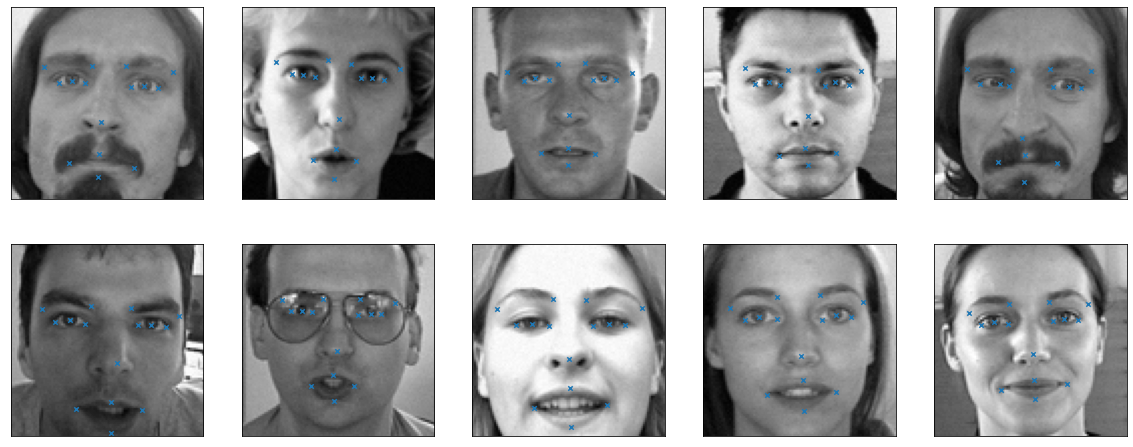

In [18]:
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data: ")
fig = plt.figure(figsize=(20,8))
for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()

if include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

# 建模

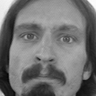

In [19]:
from PIL import Image

Image.fromarray(clean_train_images[0].reshape(-1, 96)*255).convert('P')

In [20]:
train_images = train_images.reshape(-1, 96*96)

In [21]:
train_images_df = pd.DataFrame(train_images, columns=[f"image{i}" for i in range(train_images.shape[1])])
train_keypoints_df = pd.DataFrame(train_keypoints, columns=[f"keypoint{i}" for i in range(train_keypoints.shape[1])])
train_df = pd.concat([train_images_df, train_keypoints_df], axis=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


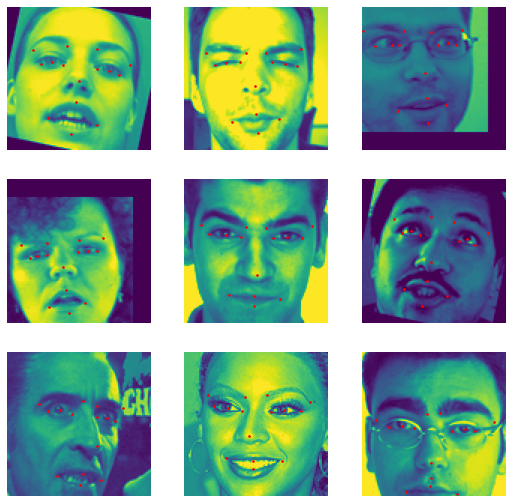

In [22]:
from fastai.vision.all import *

def str2img(row):
  imarr = np.array([row[col] for col in row.index if "image" in col])
  #imarr = np.fromstring(row.Image, dtype='int32', sep=' ').astype(np.int32)
  i = Image.fromarray(imarr.reshape(-1, 96)*255).convert('P')
  return PILImage(i)

def row2points(row): 
  points = np.array([row[col] for col in row.index if "keypoint" in col])
  a = np.reshape(points, (15,2)).astype(np.float64)
  return a


db = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_x = str2img,
    get_y = row2points,
    splitter = RandomSplitter(valid_pct=0.15, seed=42),
    #batch_tfms = aug_transforms(do_flip=False, max_zoom=1.0), # should prob adjust these params    
)
dls = db.dataloaders(train_df)
dls.show_batch()

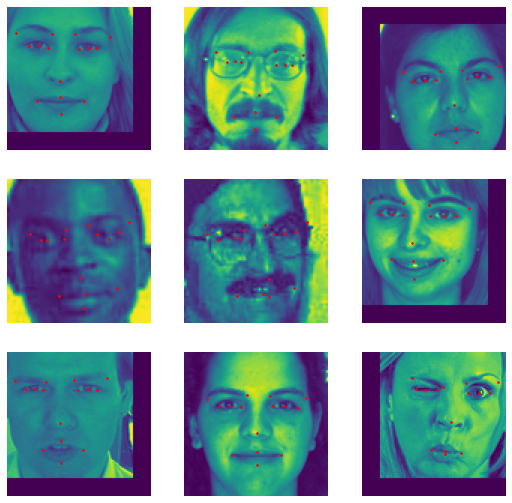

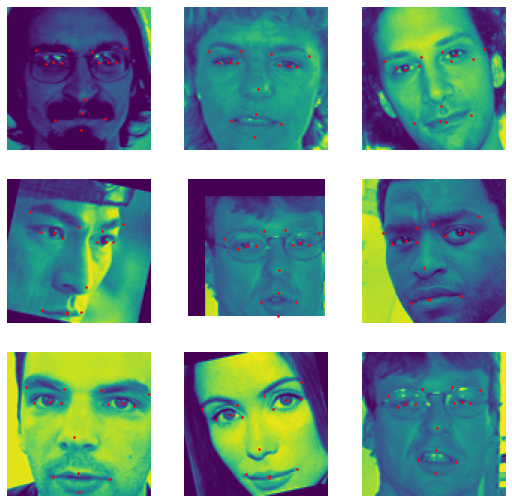

In [23]:
dls.train.show_batch()
dls.valid.show_batch()

W:\Softwares\Anaconda\envs\pytorch\lib\site-packages\fastai\vision\learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


SuggestedLRs(valley=0.0008317637839354575)

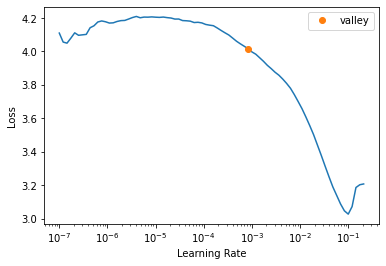

In [24]:
learn = cnn_learner(dls, resnet101)
learn.lr_find()

Path('models/after-first-finetune.pth')

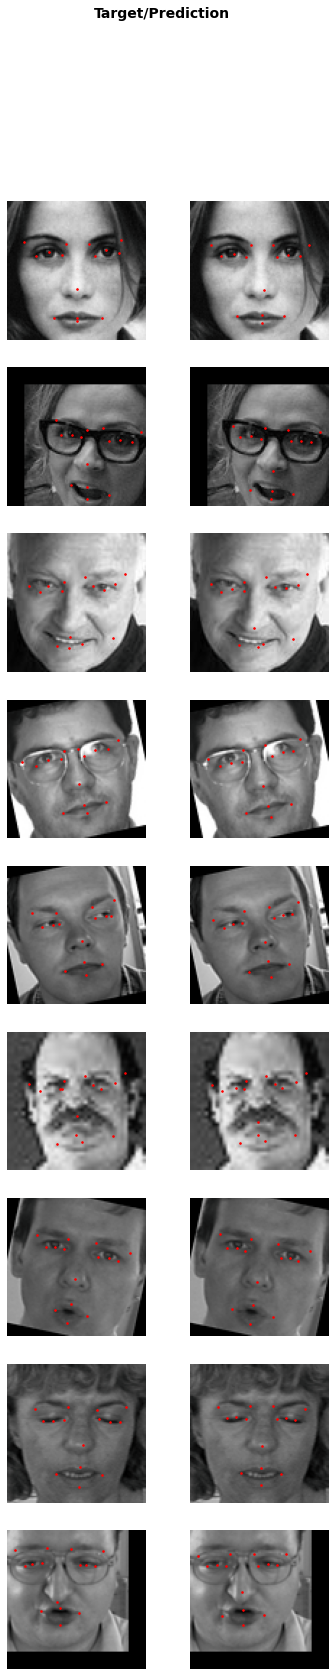

In [25]:
learn.fine_tune(10) # should really do like 50
learn.show_results()
learn.save('after-first-finetune')

In [28]:
test_images = test_images.reshape(-1, 96*96)

In [73]:
test_images.shape

(1783, 9216)

In [69]:
test_images_df = pd.DataFrame(test_images, columns=[f"image{i}" for i in range(train_images.shape[1])])
test_dl = learn.dls.test_dl(test_images_df)
pred_probas, _ classes = learn.get_preds(dl=test_dl,  with_decoded=True) 
# 这代码有问题，暂时没找出来原因。可以用来

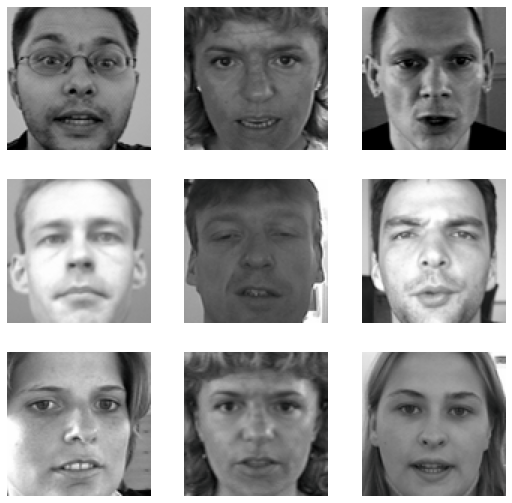

In [33]:
test_dl.show_batch()

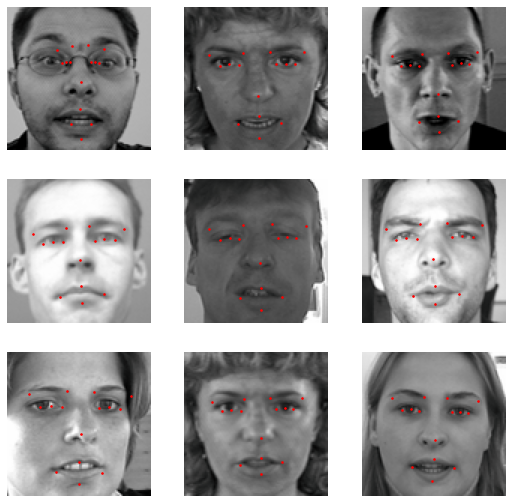

In [35]:
learn.show_results(dl=test_dl)

In [50]:
preds = [learn.predict(PILImage(str2img(test_images_df.iloc[idx])))[0] for idx in range(len(test_images_df))]
results = [x.reshape(30).numpy() for x in preds]
results = pd.DataFrame(results)
results.head()

0          1          2          3          4          5   \
0  58.357826  36.164734  38.735195  36.372868  55.572456  36.543804   
1  67.232590  37.558403  29.188553  37.868355  60.711197  38.115318   
2  65.889374  37.109451  31.933353  38.422188  59.813522  38.250637   
3  64.290924  39.430115  30.264816  41.387680  58.014198  40.380749   
4  67.825447  37.884953  29.633108  38.851578  61.678818  38.723343   

          6          7          8          9   ...         20         21  \
0  60.752937  37.155983  41.499149  36.596226  ...  48.481255  50.089882   
1  73.154236  37.942291  35.743156  38.473080  ...  48.480179  58.997005   
2  71.329987  37.644623  37.861027  39.011772  ...  50.251568  57.510818   
3  71.692474  40.215126  37.048611  41.574203  ...  47.812378  53.445862   
4  73.996307  38.796402  36.023430  39.184273  ...  50.141708  55.496651   

          22         23         24         25         26         27  \
0  55.200943  77.694672  42.324554  77.861320  48.297218  67.593254   
1  64.236115  76.871948  35.021152  77.752197  49.258614  72.525543   
2  63.527435  75.578926  37.596779  76.617477  50.384262  72.343781   
3  64.242035  76.185303  34.420750  78.055374  48.749737  70.620956   
4  64.492096  78.097076  36.434273  78.833672  50.416340  71.835541   

          28         29  
0  48.674957  87.536880  
1  49.230423  87.067474  
2  51.023014  83.291931  
3  49.111031  82.051102  
4  50.873230  86.877121  

[5 rows x 30 columns]

In [51]:
results.head()

0          1          2          3          4          5   \
0  58.357826  36.164734  38.735195  36.372868  55.572456  36.543804   
1  67.232590  37.558403  29.188553  37.868355  60.711197  38.115318   
2  65.889374  37.109451  31.933353  38.422188  59.813522  38.250637   
3  64.290924  39.430115  30.264816  41.387680  58.014198  40.380749   
4  67.825447  37.884953  29.633108  38.851578  61.678818  38.723343   

          6          7          8          9   ...         20         21  \
0  60.752937  37.155983  41.499149  36.596226  ...  48.481255  50.089882   
1  73.154236  37.942291  35.743156  38.473080  ...  48.480179  58.997005   
2  71.329987  37.644623  37.861027  39.011772  ...  50.251568  57.510818   
3  71.692474  40.215126  37.048611  41.574203  ...  47.812378  53.445862   
4  73.996307  38.796402  36.023430  39.184273  ...  50.141708  55.496651   

          22         23         24         25         26         27  \
0  55.200943  77.694672  42.324554  77.861320  48.297218  67.593254   
1  64.236115  76.871948  35.021152  77.752197  49.258614  72.525543   
2  63.527435  75.578926  37.596779  76.617477  50.384262  72.343781   
3  64.242035  76.185303  34.420750  78.055374  48.749737  70.620956   
4  64.492096  78.097076  36.434273  78.833672  50.416340  71.835541   

          28         29  
0  48.674957  87.536880  
1  49.230423  87.067474  
2  51.023014  83.291931  
3  49.111031  82.051102  
4  50.873230  86.877121  

[5 rows x 30 columns]

In [52]:
results.shape

names = [
         'left_eye_center_x','left_eye_center_y',
         'right_eye_center_x','right_eye_center_y',
         'left_eye_inner_corner_x','left_eye_inner_corner_y',
         'left_eye_outer_corner_x','left_eye_outer_corner_y',
         'right_eye_inner_corner_x','right_eye_inner_corner_y',
         'right_eye_outer_corner_x','right_eye_outer_corner_y',
         'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
         'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
         'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
         'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
         'nose_tip_x','nose_tip_y',
         'mouth_left_corner_x','mouth_left_corner_y',
         'mouth_right_corner_x','mouth_right_corner_y',
         'mouth_center_top_lip_x','mouth_center_top_lip_y',
         'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y'
]
dicty = {}
for x in range(30):
  dicty[x] = names[x]
print(dicty)
results.rename(dicty, axis='columns', inplace=True)
results['ImageId'] = range(1, 1783+1)

{0: 'left_eye_center_x', 1: 'left_eye_center_y', 2: 'right_eye_center_x', 3: 'right_eye_center_y', 4: 'left_eye_inner_corner_x', 5: 'left_eye_inner_corner_y', 6: 'left_eye_outer_corner_x', 7: 'left_eye_outer_corner_y', 8: 'right_eye_inner_corner_x', 9: 'right_eye_inner_corner_y', 10: 'right_eye_outer_corner_x', 11: 'right_eye_outer_corner_y', 12: 'left_eyebrow_inner_end_x', 13: 'left_eyebrow_inner_end_y', 14: 'left_eyebrow_outer_end_x', 15: 'left_eyebrow_outer_end_y', 16: 'right_eyebrow_inner_end_x', 17: 'right_eyebrow_inner_end_y', 18: 'right_eyebrow_outer_end_x', 19: 'right_eyebrow_outer_end_y', 20: 'nose_tip_x', 21: 'nose_tip_y', 22: 'mouth_left_corner_x', 23: 'mouth_left_corner_y', 24: 'mouth_right_corner_x', 25: 'mouth_right_corner_y', 26: 'mouth_center_top_lip_x', 27: 'mouth_center_top_lip_y', 28: 'mouth_center_bottom_lip_x', 29: 'mouth_center_bottom_lip_y'}


In [53]:
# need to go from point values as COLUMNS to point values as ROWS
sorted_results = results.melt(id_vars='ImageId', value_vars=names).sort_values(by=['ImageId'])
sorted_results['variable'] = pd.CategoricalIndex(sorted_results['variable'], names)
sorted_results.rename(columns={'variable':'FeatureName', 'value':'Location'}, inplace=True)
sorted_results.sort_values(by=['ImageId','FeatureName'], inplace=True)
sorted_results.set_index(['ImageId','FeatureName'], inplace=True)
#sortrez.head(30)

In [54]:
# and then put predictions the way the submission file wants it

look = pd.read_csv('IdLookupTable.csv')
look.set_index(['ImageId','FeatureName'], inplace=True)
look.head()

combo = look.join(sorted_results, on=['ImageId','FeatureName'], lsuffix='remove')
combo.drop(columns='Locationremove', inplace=True)
combo.reset_index(inplace=True)
combo[['RowId','ImageId','FeatureName','Location']]
combo['Location'] = combo['Location'].clip(lower=0, upper=96)
combo.describe()
#combo

ImageId         RowId      Location
count  27124.000000  27124.000000  27124.000000
mean     608.372880  13562.500000     49.154049
std      492.180504   7830.168687     17.170120
min        1.000000      1.000000      9.377824
25%      227.000000   6781.750000     36.619883
50%      454.000000  13562.500000     46.518667
75%      936.000000  20343.250000     64.836369
max     1783.000000  27124.000000     93.482117

In [55]:
combo[['RowId','Location']].to_csv('submission2.csv', index=False)